In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [13]:
df = pd.read_csv("weekly_housing_market_data_most_recent.tsv",sep="\t")
print(df.shape)

(933295, 78)


## Data Process

1. take out the county with less than 580 rows
2. Fill NaN with 0
3. Filter with county only (take out the metro)
4. join the data on region_name & period_begin, so 1 weeks and 4 weeks and 12 weeks value are in different columns
5. Create variables(total value) = total house sold * median sales price


In [15]:
df.head()

,region_id,region_type_id,region_name,region_type,period_begin,period_end,duration,total_homes_sold,total_homes_sold_yoy,average_homes_sold,...,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,percent_total_price_drops_of_inventory,percent_total_price_drops_of_inventory_yoy,last_updated
0,1508,5,"Traverse County, MN",county,2020-08-17,2020-08-23,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 14:26:38
1,44460,-2,"Steamboat Springs, CO metro area",metro,2019-10-14,2019-10-20,1 weeks,5.0,-0.761905,5.0,...,3.0,2.20,1.72381,63.40,45.780952,22.0,0.294118,0.030612,0.007885,2020-10-21 14:26:38
2,1508,5,"Traverse County, MN",county,2020-04-20,2020-04-26,1 weeks,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 14:26:38
3,3043,5,"Falls Church, VA",county,2020-04-06,2020-04-12,1 weeks,1.0,-0.833333,1.0,...,-37.0,2.00,1.00000,25.00,19.500000,4.0,-0.428571,NaN,NaN,2020-10-21 14:26:38
4,705,5,"Payette County, ID",county,2018-04-30,2018-05-06,1 weeks,4.0,-0.200000,4.0,...,-37.5,1.25,0.65000,17.25,-12.350000,8.0,NaN,0.031746,NaN,2020-10-21 14:26:38


In [16]:
df.duration.value_counts()

1 weeks     318341
4 weeks     313773
12 weeks    301181
Name: duration, dtype: int64

In [17]:
df[df.region_name=="New York County, NY"].duration.value_counts()

1 weeks     198
4 weeks     195
12 weeks    187
Name: duration, dtype: int64

In [18]:
df.region_name.value_counts()

Nevada County, CA         580
Oconto County, WI         580
Chatham County, GA        580
Racine County, WI         580
Bates County, MO          580
                         ... 
Roswell, NM metro area    392
Stonewall County, TX      387
Norman County, MN         280
Edwards, CO metro area     98
Eagle County, CO           98
Name: region_name, Length: 1614, dtype: int64

In [19]:
df.period_begin= pd.to_datetime(df.period_begin)
df.period_end= pd.to_datetime(df.period_end)
df[['region_name_1','state']] = df.region_name.str.split(",",expand=True)
df["state"] = df.state.str.strip()
county = df[df.region_name.str.find("metro area")==-1.0]

metro  = df[df.region_name.str.find("metro area")>0]

print(county.shape)
print(metro.shape)


(697908, 80)
(235387, 80)


In [20]:
county_list = county.region_name.value_counts().to_frame()
exclude_name = county_list[county_list.region_name<580].index.tolist()

exclude_name

['Daggett County, UT',
 'Lake of the Woods County, MN',
 'Jefferson County, IN',
 'Gilliam County, OR',
 'Polk County, MN',
 'Clearwater County, MN',
 'Sherman County, OR',
 'Roseau County, MN',
 'Cheyenne County, CO',
 'Harney County, OR',
 'Union County, IN',
 'Mahnomen County, MN',
 'Kittson County, MN',
 'Marshall County, MN',
 'Lawrence County, OH',
 'Pennington County, MN',
 'Red Lake County, MN',
 'Clay County, MN',
 'Cass County, IA',
 'Throckmorton County, TX',
 'Wilkin County, MN',
 'Chaves County, NM',
 'Stonewall County, TX',
 'Norman County, MN',
 'Eagle County, CO']

In [21]:
county_exclude = county[~county.region_name.isin(exclude_name)]

county_exclude_column = county[["region_name","region_name_1","state","period_begin","period_end","duration","total_homes_sold","median_sale_price"]]
county_exclude_column.total_homes_sold = county_exclude_column.total_homes_sold.fillna(0)
county_exclude_column.median_sale_price = county_exclude_column.median_sale_price.fillna(0)


county_week_1 = county_exclude_column[county_exclude_column.duration=="1 weeks"]
print(county_week_1.shape)
county_week_4 = county_exclude_column[county_exclude_column.duration=="4 weeks"]
print(county_week_4.shape)
county_week_12 = county_exclude_column[county_exclude_column.duration=="12 weeks"]
print(county_week_12.shape)
county_final = county_week_1.merge(county_week_4,on=["region_name","period_begin"],how="left",suffixes=('', '_4'))
county_final = county_final.merge(county_week_12,on=["region_name","period_begin"],how="left",suffixes=('', '_12'))

county_final.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


(238007, 8)
(234636, 8)
(225265, 8)


,region_name,region_name_1,state,period_begin,period_end,duration,total_homes_sold,median_sale_price,region_name_1_4,state_4,period_end_4,duration_4,total_homes_sold_4,median_sale_price_4,region_name_1_12,state_12,period_end_12,duration_12,total_homes_sold_12,median_sale_price_12
0,"Traverse County, MN",Traverse County,MN,2020-08-17,2020-08-23,1 weeks,0.0,0.0,Traverse County,MN,2020-09-13,4 weeks,2.0,67250.0,NaN,NaN,NaT,NaN,NaN,NaN
1,"Traverse County, MN",Traverse County,MN,2020-04-20,2020-04-26,1 weeks,0.0,0.0,Traverse County,MN,2020-05-17,4 weeks,1.0,55000.0,Traverse County,MN,2020-07-12,12 weeks,1.0,55000.0
2,"Falls Church, VA",Falls Church,VA,2020-04-06,2020-04-12,1 weeks,1.0,1763499.0,Falls Church,VA,2020-05-03,4 weeks,16.0,1215550.5,Falls Church,VA,2020-06-28,12 weeks,41.0,931109.2
3,"Payette County, ID",Payette County,ID,2018-04-30,2018-05-06,1 weeks,4.0,104400.0,Payette County,ID,2018-05-27,4 weeks,20.0,185162.3,Payette County,ID,2018-07-22,12 weeks,82.0,174066.6
4,"Nye County, NV",Nye County,NV,2017-01-16,2017-01-22,1 weeks,6.0,187500.0,Nye County,NV,2017-02-12,4 weeks,42.0,186750.0,Nye County,NV,2017-04-09,12 weeks,128.0,180970.8


In [22]:
county_final["day_of_year"] = county_final.period_begin.dt.dayofyear

In [23]:
county_final_final = county_final[["region_name_1","state","period_begin","day_of_year","period_end","total_homes_sold","median_sale_price","period_end_4","total_homes_sold_4","median_sale_price_4","period_end_12","total_homes_sold_12","median_sale_price_12"]]
county_final_final.head()

,region_name_1,state,period_begin,day_of_year,period_end,total_homes_sold,median_sale_price,period_end_4,total_homes_sold_4,median_sale_price_4,period_end_12,total_homes_sold_12,median_sale_price_12
0,Traverse County,MN,2020-08-17,230,2020-08-23,0.0,0.0,2020-09-13,2.0,67250.0,NaT,NaN,NaN
1,Traverse County,MN,2020-04-20,111,2020-04-26,0.0,0.0,2020-05-17,1.0,55000.0,2020-07-12,1.0,55000.0
2,Falls Church,VA,2020-04-06,97,2020-04-12,1.0,1763499.0,2020-05-03,16.0,1215550.5,2020-06-28,41.0,931109.2
3,Payette County,ID,2018-04-30,120,2018-05-06,4.0,104400.0,2018-05-27,20.0,185162.3,2018-07-22,82.0,174066.6
4,Nye County,NV,2017-01-16,16,2017-01-22,6.0,187500.0,2017-02-12,42.0,186750.0,2017-04-09,128.0,180970.8


In [24]:
county_final_final.to_csv('housing_county.csv', index = False)  #convert df to csv, saved to root

In [25]:
import math
#pd.set_option("display.max_rows", None, "display.max_columns", None)
d_region = county_final_final.groupby(["state"]).agg({"region_name_1":"nunique"}).sort_values("region_name_1",ascending=False)
d_region["state"] = d_region.index
d_region = d_region.reset_index(drop=True)
print(d_region.state.count())
print(d_region)
print(d_region.dtypes)

47
    region_name_1 state
0              92    TX
1              87    MN
2              72    WI
3              53    TN
4              50    VA
5              48    OH
6              45    KY
7              44    GA
8              44    MO
9              40    NC
10             39    MI
11             38    NY
12             36    CA
13             33    FL
14             31    IL
15             29    OR
16             28    CO
17             28    AR
18             27    PA
19             27    WA
20             25    IN
21             24    MD
22             22    OK
23             21    NJ
24             20    SC
25             19    LA
26             19    AL
27             18    UT
28             16    ME
29             14    VT
30             13    ID
31             11    NV
32             10    MA
33             10    IA
34             10    NE
35             10    NH
36              8    CT
37              7    WV
38              7    NM
39              7    KS
40           

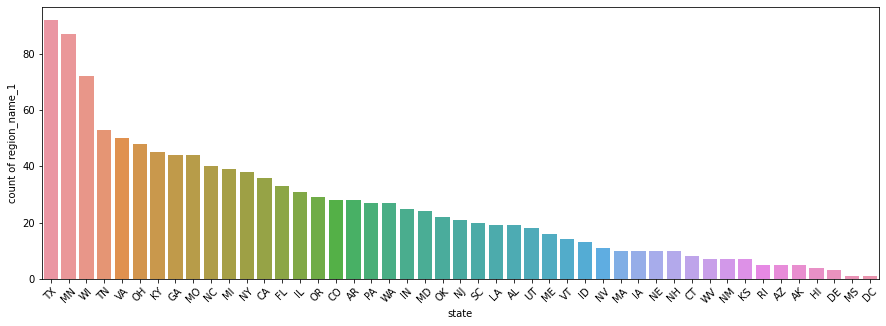

In [26]:

plt.figure(figsize=(15,5))
sns.barplot(x="state",y="region_name_1",data=d_region)
plt.xticks(rotation=45)
plt.ylabel("count of region_name_1")
plt.show()

In [27]:
county_final_final["total_value"] = county_final_final["total_homes_sold"] * county_final_final["median_sale_price"]


agg = county_final_final.groupby(["state","period_begin"]).agg({"total_homes_sold":"sum","total_value":"sum"}).reset_index()
agg["AVG_median_sales_price"] = agg["total_value"]/agg["total_homes_sold"]

<ipython-input-27-893bfcc39569>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_final_final["total_value"] = county_final_final["total_homes_sold"] * county_final_final["median_sale_price"]


In [28]:
agg

,state,period_begin,total_homes_sold,total_value,AVG_median_sales_price
0,AK,2017-01-02,81.0,21202000.0,261753.086420
1,AK,2017-01-09,95.0,28384895.0,298788.368421
2,AK,2017-01-16,86.0,22529900.0,261975.581395
3,AK,2017-01-23,105.0,26613000.0,253457.142857
4,AK,2017-01-30,116.0,32739500.0,282237.068966
...,...,...,...,...,...
9301,WV,2020-09-14,114.0,29374275.0,257669.078947
9302,WV,2020-09-21,99.0,22832950.0,230635.858586
9303,WV,2020-09-28,161.0,40988440.0,254586.583851
9304,WV,2020-10-05,116.0,23419074.0,201888.568966


In [29]:
agg.to_csv('housing_state.csv', index = False)

In [30]:
def plot_home_sold_value(df,state):
    agg_sub = agg[agg.state ==state]
    fig = plt.figure(figsize=(15,10))

    ax1 = fig.add_subplot(313)

    ax1.plot(agg_sub.period_begin,agg_sub.total_homes_sold)
    ax1.set_title("Total homes sold")
    

    ax2 = fig.add_subplot(312)
    ax2.plot(agg_sub.period_begin,agg_sub.total_value)
    ax2.set_title("Total value")
    
    ax3 = fig.add_subplot(311)
    ax3.plot(agg_sub.period_begin,agg_sub.AVG_median_sales_price)
    ax3.set_title("Avg_median_sales_price(weighted)")
    
    plt.show()
    

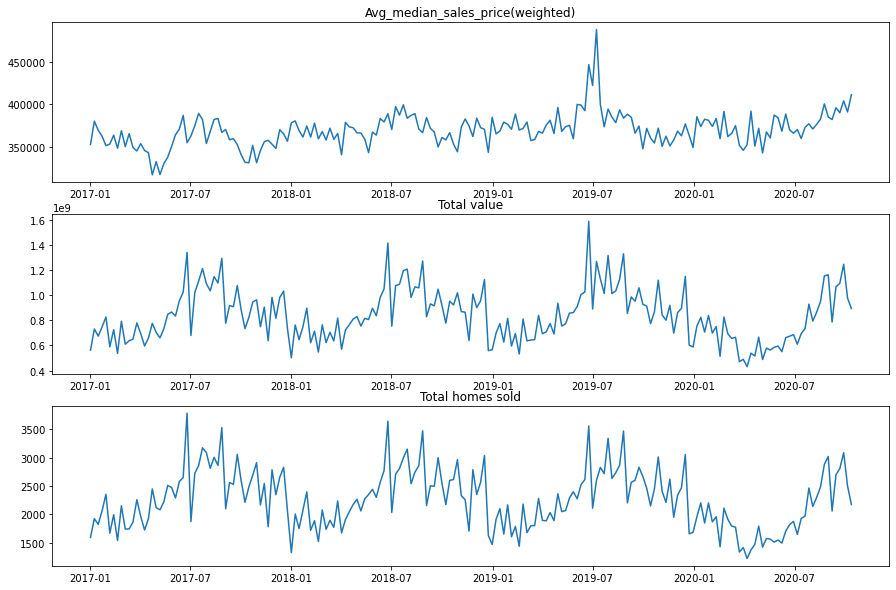

In [31]:
plot_home_sold_value(agg,"NY")

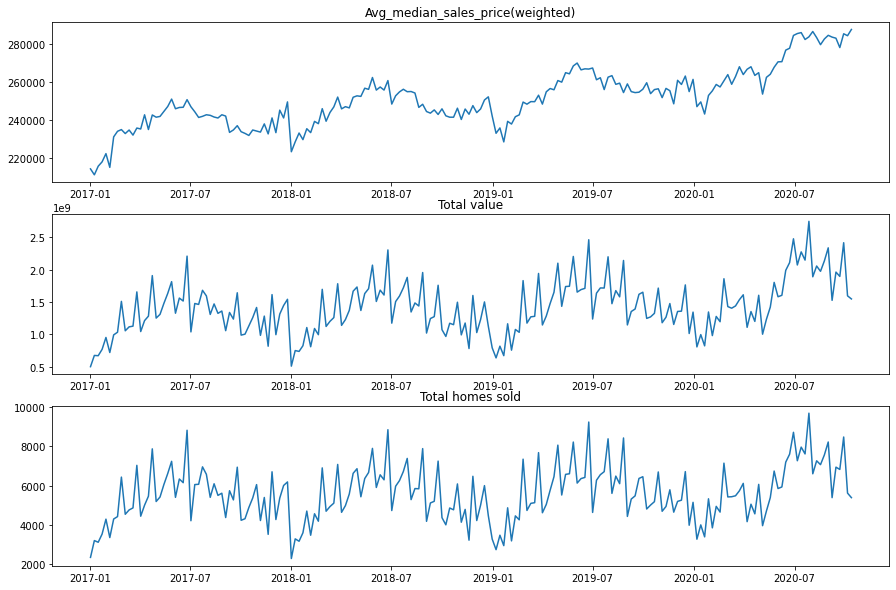

In [32]:
plot_home_sold_value(agg,"TX")